In [2]:
import os
import uuid
import shutil
#import pylatex
import pandas as pd
import lightkurve as lk 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from datetime import datetime
from tqdm.notebook import tqdm
from multiprocessing import cpu_count, Pool
#from pylatex.section import Chapter, Subsection
#from pylatex import Document, Section, Figure, NoEscape, Command

%run pipeline.ipynb

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [3]:
# bestlcs=pd.read_csv('makingtable/bestlcs.csv')
# bestlclist=np.array([], dtype=object)
# start_col=bestlcs.columns.get_loc('Sector 1')
# for index, row in bestlcs.iterrows(): #iterate through each object
#     for col in bestlcs.columns[start_col:]: #iterate through all the columns starting with the sectors
#         value=row[col]
#         if not pd.isna(value):
#             bestlclist=np.append(bestlclist, [f'{row['pop_id']}_{value}'])

In [4]:
# K2SFFlist=np.loadtxt('makingtable/K2SFFlist.txt', dtype=str)
# lclist=pd.concat([pd.DataFrame(bestlclist), pd.DataFrame(K2SFFlist)], ignore_index=True)
# lclist[['pop_id', 'lcname']]=lclist[0].str.split('_', expand=True)
# lclist.drop(columns=0, inplace=True)

In [5]:
#lclist=pd.read_csv('periodtable.csv')

In [6]:
#lclist['complex_status']=""

In [7]:
#lclist=pd.read_csv('lcnameswithstatus.csv')

In [8]:
coltypes={'ID':str,'TIC':str,'gaiadr3_source_id':str,'epic_id':str,'Score':'Int64','Flare':'Int64',
          'Shelf':'Int64','Evolution':'Int64','Score.1':'Int64','Flare.1':'Int64','Shelf.1':'Int64','Evolution.1':'Int64'}

In [9]:
lctable=pd.read_csv('lightcurvescores.csv',header=1,dtype=coltypes)

In [10]:
lctable.rename(columns={'author_x':'LC_author','author_y':'paper_author','Score':'Score1','Flare':'Flare1',
                        'Shelf':'Shelf1','Evolution':'Evolution1','Notes':'Notes1','Score.1':'Score2',
                        'Flare.1':'Flare2','Shelf.1':'Shelf2','Evolution.1':'Evolution2','Notes.1':'Notes2'},inplace=True)

In [11]:
lctable.drop(['calc_per','complex_status'],axis=1,inplace=True)

In [12]:
lctable['complex_status1']=''
lctable['complex_status2']=''

In [13]:
lctable.head(20)

,pop_id,lcname,idtype,ID,secorcamp,LC_author,cadence,fluxamplitude,TIC,gaiadr3_source_id,epic_id,per,per2,group,age_Myr,disco_paper,paper_author,year,Score1,Flare1,Shelf1,Evolution1,Notes1,Score2,Flare2,Shelf2,Evolution2,Notes2,complex_status1,complex_status2
0,0,EPIC-246676629-13-EVEREST-1800,EPIC,246676629,13,EVEREST,1800,0.075449,59129133,3392549449695395968,246676629,0.6253,0.6332,Taurus,2.0,Stauffer_2018,Stauffer,2018,2,0,0,1,NaN,1,0,0,0,Very hard to tell what's going on,,
1,0,EPIC-246676629-13-K2SFF-1800,EPIC,246676629,13,K2SFF,1800,0.083411,59129133,3392549449695395968,246676629,0.6253,0.6332,Taurus,2.0,Stauffer_2018,Stauffer,2018,2,0,0,0,EVEREST is actually better for this object,1,0,0,0,Cadence has lined up weirdly with period,,
2,0,TIC-59129133-5-FFI-30min,TIC,59129133,5,FFI,30min,0.041935,59129133,3392549449695395968,246676629,0.6253,0.6332,Taurus,2.0,Stauffer_2018,Stauffer,2018,2,1,0,1,NaN,1,1,0,1,NaN,,
3,0,TIC-59129133-32-FFI-10min,TIC,59129133,32,FFI,10min,0.053793,59129133,3392549449695395968,246676629,0.6253,0.6332,Taurus,2.0,Stauffer_2018,Stauffer,2018,2,0,0,1,NaN,2,0,0,0,NaN,,
4,0,TIC-59129133-43-SPOC-120,TIC,59129133,43,SPOC,120,0.053993,59129133,3392549449695395968,246676629,0.6253,0.6332,Taurus,2.0,Stauffer_2018,Stauffer,2018,2,2,1,1,NaN,2,2,0,1,Literature period might be a little off,,
5,0,TIC-59129133-44-SPOC-120,TIC,59129133,44,SPOC,120,0.056758,59129133,3392549449695395968,246676629,0.6253,0.6332,Taurus,2.0,Stauffer_2018,Stauffer,2018,2,2,0,1,NaN,2,2,0,1,NaN,,
6,0,TIC-59129133-71-FFI-200s,TIC,59129133,71,FFI,200s,0.049836,59129133,3392549449695395968,246676629,0.6253,0.6332,Taurus,2.0,Stauffer_2018,Stauffer,2018,2,0,1,1,NaN,2,0,0,0,Can't really see the behavior of this period o...,,
7,1,EPIC-246682490-13-K2SFF-1800,EPIC,246682490,13,K2SFF,1800,0.049147,59091144,3392553852037339776,246682490,0.4377,3.6324,Taurus,2.0,Stauffer_2018,Stauffer,2018,9,0,0,0,NaN,0,0,0,0,NaN,,
8,1,EPIC-246682490-13-EVEREST-1800,EPIC,246682490,13,EVEREST,1800,0.396351,59091144,3392553852037339776,246682490,0.4377,3.6324,Taurus,2.0,Stauffer_2018,Stauffer,2018,2,0,0,1,NaN,0,0,0,1,NaN,,
9,1,TIC-59091144-5-FFI-30min,TIC,59091144,5,FFI,30min,0.023516,59091144,3392553852037339776,246682490,0.4377,3.6324,Taurus,2.0,Stauffer_2018,Stauffer,2018,1,0,0,0,Cadence lines up weirdly with period,0,0,0,0,NaN,,


In [14]:
for index, currow in lctable.iterrows(): 
    #if not currow['complex_status1']=='':
        #continue
    try:
        curlc=get_lc_string(currow['lcname'])
        complexity1,_= harmonic_checker(curlc,period=currow['per'],percentage=0.10)
        lctable.at[index,'complex_status1']=complexity1
        if not pd.isna(currow['per2']):
            complexity2,_= harmonic_checker(curlc,period=currow['per2'],percentage=0.10)
            lctable.at[index,'complex_status2']=complexity2
    except Exception as e:
        print(f'Error getting complex status for {currow['lcname']}: {e}')

Error getting complex status for TIC-404335106-38-FFI-10min: index -1 is out of bounds for axis 0 with size 0


Error getting complex status for TIC-300651846-13-FFI-30min: index -1 is out of bounds for axis 0 with size 0
Error getting complex status for TIC-442571495-91-FFI-200s: index -1 is out of bounds for axis 0 with size 0


Error getting complex status for TIC-442575691-91-FFI-200s: index -1 is out of bounds for axis 0 with size 0


No data found for target "EPIC 60019763".


Error getting complex status for EPIC-60019763-1-K2SFF-1800: 'NoneType' object has no attribute 'to_periodogram'


Error getting complex status for TIC-244161191-42-FFI-10min: index -1 is out of bounds for axis 0 with size 0


In [15]:
lctable[np.logical_and(np.logical_or(lctable.complex_status1=='',
                                     np.logical_and(lctable.complex_status2=='',
                                                    np.logical_not(pd.isna(lctable.per2)))),
                      np.logical_not(lctable.Notes1=="Didn't plot"))]

,pop_id,lcname,idtype,ID,secorcamp,LC_author,cadence,fluxamplitude,TIC,gaiadr3_source_id,epic_id,per,per2,group,age_Myr,disco_paper,paper_author,year,Score1,Flare1,Shelf1,Evolution1,Notes1,Score2,Flare2,Shelf2,Evolution2,Notes2,complex_status1,complex_status2


In [16]:
#np.unique(lclist[pd.isna(lclist.complex_status)]['author_x'],return_counts=True)

In [17]:
#np.unique(lclist[np.logical_not(pd.isna(lclist.complex_status))]['author_x'],return_counts=True)

In [18]:
#lclist.sort_values(by=['pop_id','idtype','secorcamp'],inplace=True)

In [19]:
#lclist['epic_id']=lclist['epic_id'].astype(pd.Int64Dtype()).astype(str)

In [20]:
#id_table=pd.read_csv('makingtable/idswithdiscopaper.csv',dtype={'gaiadr3_source_id':str})

In [21]:
#id_table=id_table[['pop_id','gaiadr3_source_id']]

In [22]:
#merged=pd.merge(lclist,id_table,on='pop_id',how='left')

In [23]:
#merged.gaiadr3_source_id_x=merged.gaiadr3_source_id_y

In [24]:
#merged.drop('gaiadr3_source_id_y',axis=1,inplace=True)

In [25]:
#merged.rename(columns={'gaiadr3_source_id_x':'gaiadr3_source_id'},inplace=True)

In [26]:
#merged.to_csv('lcnameswithstatus.csv',index=False)

In [27]:
lctable.to_csv('lcscoresandchecker.csv',index=False)

In [28]:
curlc=get_lc_string('TIC-84187344-39-FFI-10min')

In [29]:
harmonic_checker(curlc,period=3.976900)

('No Harmonic Spikes', 3.9769)

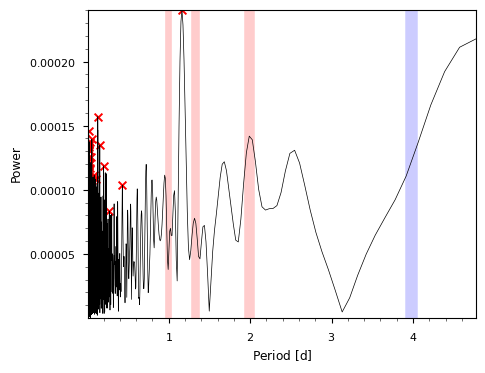

In [30]:
subgraph_pg(curlc,period=u.Quantity(3.976900,u.d))